In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aeons.utils import *
from aeons.regress import *
from aeons.endpoint import *
from aeons.plotting import *
from aeons.beta import *
figsettings()
from beta import *

In [4]:
!python inferences.py gauss_32

Loaded chain gauss_32
 Iteration 52289 of 52289Wrote d_Gs and logXfs to data/d_Gs and data/logXfs


In [11]:
name, samples = get_samples('gauss_16')
iterations, logXfs, logXfs_std, d_Gs, d_Gs_std, true_endpoint = read_from_txt('data/inferences/post_log/gauss_16.txt')

In [17]:
def logXfs_post(points, ndead, Nset=25):
    d_G = get_d_G_post(points, ndead)[0]
    mean, std = d_G.mean(), d_G.std()
    
    logL, X_mean, nk, logZdead = data(points)
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        d = np.random.normal(mean, std)
        while d < 0:
            d = np.random.normal(mean, std)
        theta = params_from_d(logL[ndead:], X[ndead:], d)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
        if np.isnan(logXf_set[i]):
            print(mean, std)
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    # logXf_set = reject_outliers(logXf_set)
    return logXf_set, f"{len(logXf_set)} samples, {d_G.mean():.1f}"

def inferences_post(points, ndead, Nset=25):
    d_G = get_d_G_post(points, ndead)[0]
    mean, std = d_G.mean(), d_G.std()
    
    logL, X_mean, nk, logZdead = data(points)
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        d = np.random.normal(mean, std)
        while d < 0:
            d = np.random.normal(mean, std)
        theta = params_from_d(logL[ndead:], X[ndead:], d)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
        if np.isnan(logXf_set[i]):
            print(mean, std)
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    # logXf_set = reject_outliers(logXf_set)
    return [logXf_set, d_G], f"{len(logXf_set)} samples, {d_G.mean():.1f}"

def inferences(model, method, iterations, **kwargs):
    samples = model.samples
    logXfs, logXfs_std = np.zeros(len(iterations)), np.zeros(len(iterations))
    d_Gs, d_Gs_std = np.zeros(len(iterations)), np.zeros(len(iterations))
    for i, ndead in enumerate(iterations):
        points = points_at_iteration(samples, ndead).recompute()
        [logXf_set, d_G_set], message = method(points, ndead, **kwargs)
        logXfs[i], logXfs_std[i] = logXf_set.mean(), logXf_set.std()
        d_Gs[i], d_Gs_std[i] = d_G_set.mean(), d_G_set.std()
        print('\r', f"Iteration {ndead} of {iterations[-1]}, {message}", end='')
    return logXfs, logXfs_std, d_Gs, d_Gs_std

def get_betas(model, method, iterations):
    samples = model.samples
    logbetas, logbetas_std = np.zeros(len(iterations)), np.zeros(len(iterations))
    for i, ndead in enumerate(iterations):
        points = points_at_iteration(samples, ndead)
        args = method(points, ndead)
        if isinstance(args, float):
            logbetas[i] = args
        else:
            logbetas[i], logbetas_std[i] = args
        print('\r', f"Iteration {ndead} of {iterations[-1]}, logbeta={logbetas[i]:.1f}", end='')
    return logbetas, logbetas_std

def get_beta_grad(points, ndead):
    logX = points.logX()
    logL = points.logL
    return np.log(-(logX.iloc[ndead+250] - logX.iloc[ndead-250])/(logL.iloc[ndead+250] - logL.iloc[ndead-250]))

In [163]:
name, samples = get_samples('gp')
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

In [97]:
iterations = make_iterations(true_endpoint, 25)
ndead = iterations[-1]
points = points_at_iteration(samples, ndead)
logXfs, d_Gs = inferences_post(points, ndead, Nset=25)[0]

In [133]:
from anesthetic.utils import quantile
from anesthetic.plot import quantile_plot_interval
q1 = quantile_plot_interval(1)
q2 = quantile_plot_interval(2)

In [164]:
iterations = make_iterations(true_endpoint, 25)
logXfs_1, logXfs_2 = np.zeros((len(iterations), 2)), np.zeros((len(iterations), 2))
d_Gs_1, d_Gs_2 = np.zeros((len(iterations), 2)), np.zeros((len(iterations), 2))
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logXfs, d_Gs = inferences_post(points, ndead, Nset=25)[0]
    logXfs_1[i], d_Gs_1[i] = quantile(logXfs, q=q1), quantile(d_Gs, q=q1)
    logXfs_2[i], d_Gs_2[i] = quantile(logXfs, q=q2), quantile(d_Gs, q=q2)
    print('\r', f"Iteration {ndead} of {iterations[-1]}", end='')

 Iteration 73560 of 88088

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/denominator


98.67349992698968 145.53874732401988
 Iteration 88088 of 88088

(0.0, 200.0)

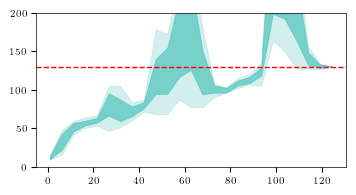

In [168]:
logXs = samples.logX().iloc[iterations]
plt.figure(figsize=(4,2))
plt.axhline(-true_logXf, color='red', ls='--', lw=1)
plt.fill_between(-logXs, *-logXfs_1.T, color='lightseagreen', alpha=0.5)
plt.fill_between(-logXs, *-logXfs_2.T, color='lightseagreen', alpha=0.2)
plt.ylim(0, 200)

plt.figure(figsize=(6,3))
plt.fill_between(-logXs, *d_Gs_1.T, color='lightseagreen', alpha=0.5)
plt.fill_between(-logXs, *d_Gs_2.T, color='lightseagreen', alpha=0.2)
plt.axhline(samples.d_G(), color='red', lw=.5, ls='--')
plt.ylim(0, 50)

In [100]:
q = quantile_plot_interval(1)
quantile(d_Gs, q=q)

array([12.37009411, 16.37774956])

<Axes: ylabel='Frequency'>

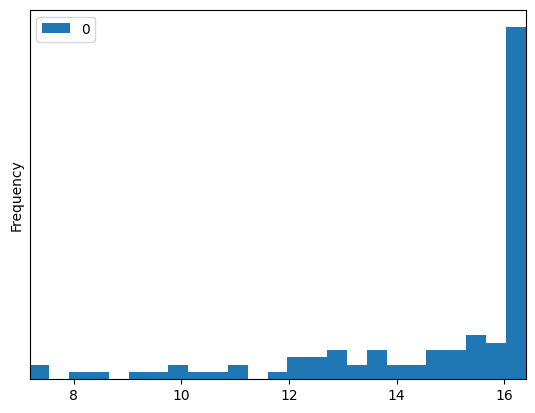

In [101]:
from anesthetic import Samples
Samples(d_Gs).plot.hist(bins=25)

In [86]:
iterations = make_iterations(true_endpoint, 25)
logXs = samples.logX().iloc[iterations]
logbetas_grad, _ = get_betas(model, get_beta_grad, iterations) 

 Iteration 51233 of 51233, logbeta=0.71

In [63]:
iterations = make_iterations(true_endpoint, 25)
logXs = samples.logX().iloc[iterations]
logbetas, logbetas_std = get_betas(model, get_beta_post, iterations)

 Iteration 51233 of 51233, logbeta=0.82

In [52]:
betas_logL = get_betas_logL(samples)

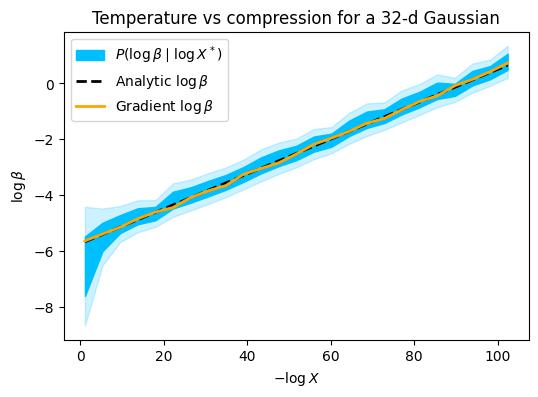

In [88]:
plot_std(-logXs, logbetas, logbetas_std, label=f'$P(\\log \\beta \\mid \\log X^* )$')
plt.plot(-logXs, np.log(get_beta_analytic(logXs, 32, 0.01)), color='black', ls='--', lw=2, label='Analytic $\\log\\beta$')
plt.plot(-logXs, logbetas_grad, color='orange', lw=2, label='Gradient $\\log\\beta$')
# plt.plot(-logXs, np.log(betas_logL[iterations]), lw=2, color='red', label="$\\langle \\log L \\rangle_{{\\mathcal{P}(\\beta)}} = \\log L^* $")
plt.gcf().set_size_inches(6,4)
plt.xlabel(r"$-\log X$")
plt.ylabel(r'$\log \beta$')
# plt.axvline(float(-model.true_logXf(0.5)), lw=1, ls='--')
# plt.axhline(0, ls='--', lw=1)
plt.legend()
plt.title('Temperature vs compression for a 32-d Gaussian');

 Iteration 16334 of 16334, 100 samples

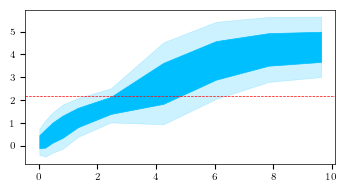

In [210]:
iterations = make_iterations(true_endpoint, 10)
logXs = samples.logX().iloc[iterations]
d_Gs, d_Gs_std = model.d_Gs(get_d_G_post, iterations)
plot_std(-logXs, d_Gs, d_Gs_std, samples.d_G())

In [185]:
betas_logL = get_betas_logL(samples)

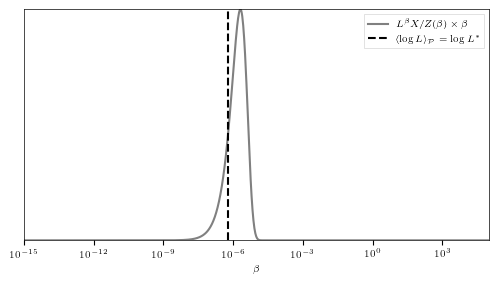

In [217]:
ndead = 2000
points = points_at_iteration(samples, ndead)
betas = np.logspace(-15, 5, 1000)
logX = points.logX()
logLbetaX = points._betalogL(betas).add(logX, axis=0)
logPlogXbeta = logLbetaX - points.logZ(beta=betas)
logZlive = logsumexp(points.logw(beta=betas).iloc[ndead:], axis=0)
Plogbeta = np.exp(logPlogXbeta + np.log(betas)).iloc[ndead]

Plogbeta.plot(logx=True, label = f'$L^\\beta X/Z(\\beta) \\times \\beta$', color='gray')
# Pbeta_minus.plot(logx=True, label = f'$|L^\\beta X - Z(\\beta)|$', color='violet')
plt.axvline(betas_logL[ndead], label="$\\langle \\log L \\rangle_\\mathcal{P} = \\log L^* $", color='black', ls='--')
plt.xlabel("$\\beta$")
plt.yticks([np.exp(logX.iloc[ndead])], [f"$X^*$ = {np.exp(logX.iloc[ndead]):.2f}"])
plt.margins(0, 0)
plt.ylabel(f'')
plt.legend()
plt.gcf().set_size_inches(6, 3)

In [656]:
name, samples = get_samples('BAO')
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

(-10.99883748603385, 0.006637590479002391)

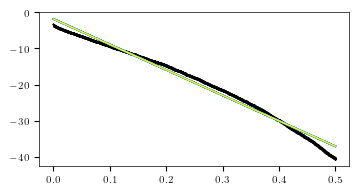

In [661]:
ndead = 5000
points = model.points(ndead)
logL, X_mean, nk, logZdead = data(points)
logLd, Xd = logL[ndead:], X_mean[ndead:]

d = 2
theta_max = params_from_d(logLd, Xd, d)
Lsq_min = np.square(logLd - full.func(Xd, theta_max)).sum()
s = np.sqrt(Lsq_min/len(logLd))

import jax
import jax.numpy as jnp
phi_max = jnp.array([theta_max[0], theta_max[2]])
def func(phi):
    logLmax, sigma = phi
    theta = jnp.array([logLmax, d, sigma])
    loss = logLd - full.func(Xd, theta)
    L_sq = jnp.sum(loss**2)
    return -1/2 * len(logLd) * jnp.log(2*jnp.pi*s**2) - L_sq/(2*s**2)
hess = jax.hessian(func)(phi_max)
cov = np.linalg.inv(-hess)

plt.plot(Xd, logLd, 'x', ms=1, color='black')
logXf = np.zeros(25)
for i in range(25):
    logLp, sigmap = np.random.multivariate_normal(phi_max, cov)
    t = [logLp, d, sigmap]
    logXf[i] = logXf_formula(t, logZdead, X_mean[ndead])
    plt.plot(Xd, full.func(Xd, t), color='dodgerblue', lw=1)
plt.plot(Xd, full.func(Xd, theta_max), color='yellow', lw=1)
logXf.mean(), logXf.std()